# Exploration of Non Text Features 



In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
%matplotlib inline

# plotting magic

sns.set_style("darkgrid")

from pylab import rcParams
import matplotlib.pylab as plt
rcParams['figure.figsize'] = 14, 5

In [7]:
# Load all od the data into a DataFrame for easy manipulation
base = "/Users/JasonLiu/Downloads/drinking/predict/"
df = pd.concat([pd.DataFrame.from_csv(base+f) for f in os.listdir(base)])

In [8]:
# Create a series that converts the `created_at` column into
# timeseries index, errors=1 amd coerse=1 since there are some errors in our data...
tm = pd.to_datetime(df.created_at, errors=1, coerce=1)

In [9]:
# Unfortunate newlineing csv reading bugs... oh well.
tm[tm.isnull()].head(5)

_id
https://t.co/R5odUktaJJ        NaT
#cats http://t.co/RFl0pLWAxE   NaT
#ThisDayInNBAHistory           NaT
#YallYounginsDontEvenKnow      NaT
#ShrugGame                     NaT
Name: created_at, dtype: datetime64[ns]

In [10]:
df["time"] = tm                              # set time to the timeseries
df = df[~tm.isnull()]                        # remove NaT columns
dt = df.set_index("time")                    # set the TimeSeries index
dt["dayofweek"] = dt.index.dayofweek         # set day of week
dt["hourofday"] = dt.index.hour              # set hour of day

# Text Length as a Predictor

In [11]:
dtext = df[["text", "predict"]]

In [12]:
dtext["alcohol"] = (dtext.predict > 0.75).apply(int)

In [13]:
dtext["length_mean"] = dtext.text.str.len()
dtext["length_std"] = dtext.text.str.len()

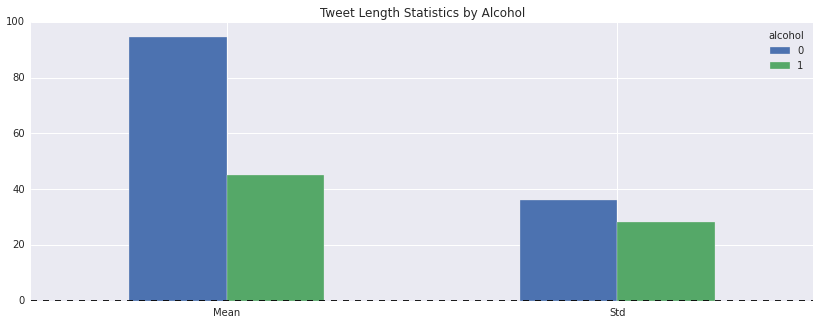

In [14]:
ax = dtext.groupby("alcohol").agg({
    "length_mean":np.mean,
    "length_std":np.std
}).T.plot(
    kind="bar"
)
ax.set_xticklabels(["Mean", "Std"], rotation=0)
ax.set_title("Tweet Length Statistics by Alcohol")
print()

# Helpers and Plotters

In [15]:
def interval_sum(a, b):
    return lambda x: np.sum((a < x) & (x < b))

In [16]:
def groupby(table, key, predict_thres=.7):
    gb = table.groupby(key).agg({
        "user":len,
        "predict": interval_sum(0.70, 1.0)
    })
    gb.columns = ["Drinking Tweets", "All Tweets"]
    gb["Drinking Tweets"] /= gb["Drinking Tweets"].sum()
    gb["All Tweets"] /= gb["All Tweets"].sum()
    return gb

def plot_groupby(gb, title, diff=False, kind="bar", **kwargs):
    ax = ((gb["Drinking Tweets"] - gb["All Tweets"]) if diff else gb).plot(
            title=title,
            kind=kind,
            **kwargs
        )
    return ax

## Day of Week as a Predictor


In [17]:
dayofweek = groupby(dt, "dayofweek")

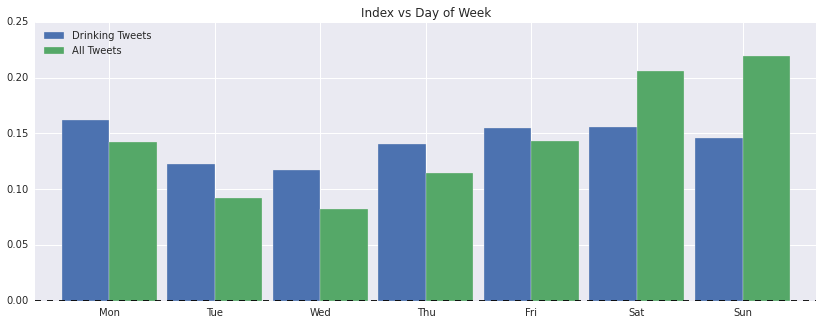

In [18]:
ax = plot_groupby(dayofweek, "Index vs Day of Week", width=.9)
ax.set_xticklabels(
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0)
ax.set_xlabel("")
ax

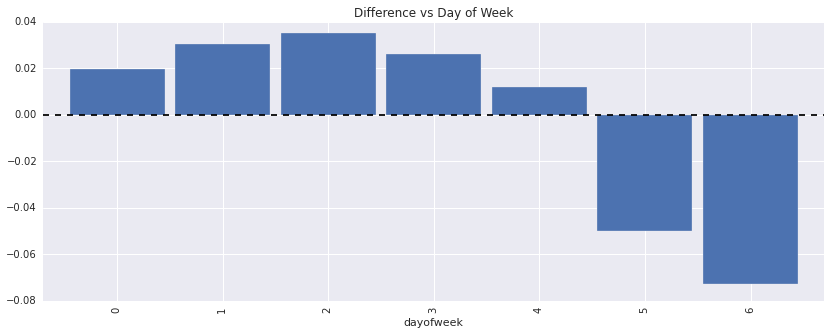

In [19]:
plot_groupby(dayofweek, "Difference vs Day of Week", diff=1, width=.9)

## Time of Day as a predictor

In [20]:
hourofday = groupby(dt, "hourofday")

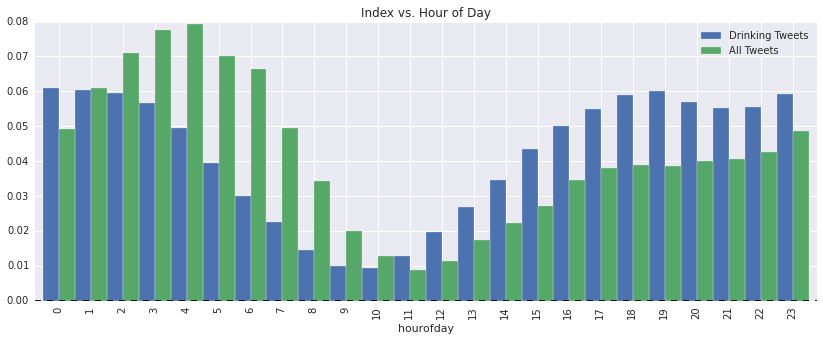

In [21]:
plot_groupby(hourofday, "Index vs. Hour of Day", width=1)

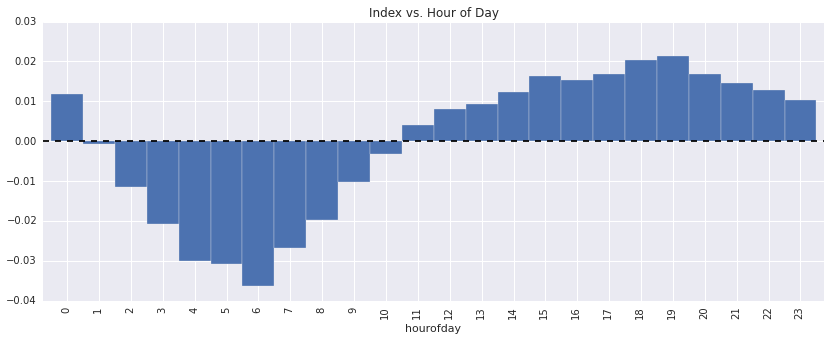

In [22]:
plot_groupby(hourofday, "Index vs. Hour of Day", diff=1, width=1)

## Day of Week*Time of Day as a Predictor

In [23]:
from itertools import product
dayhour = groupby(dt, ["dayofweek", "hourofday"])

xt  = list(range(0, 7*24))[::12]
xtl = list(
        map(", ".join,
             product(
                ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
                map(str, range(0, 24)))))[::12]

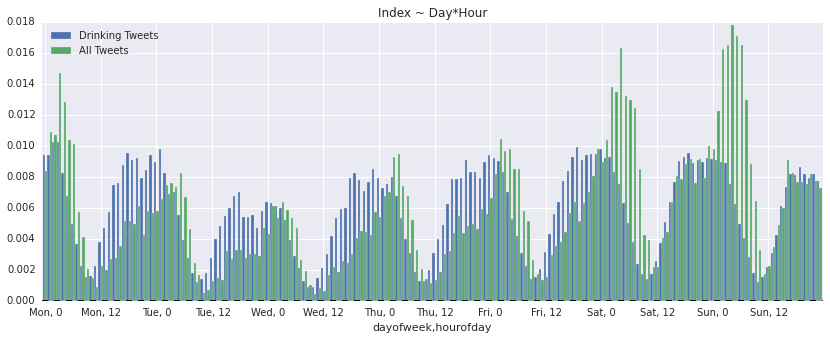

In [24]:
ax = plot_groupby(dayhour, "Index ~ Day*Hour", kind="bar", width=1)
ax.set_xticks(xt)
ax.set_xticklabels(xtl, rotation=0)
print()

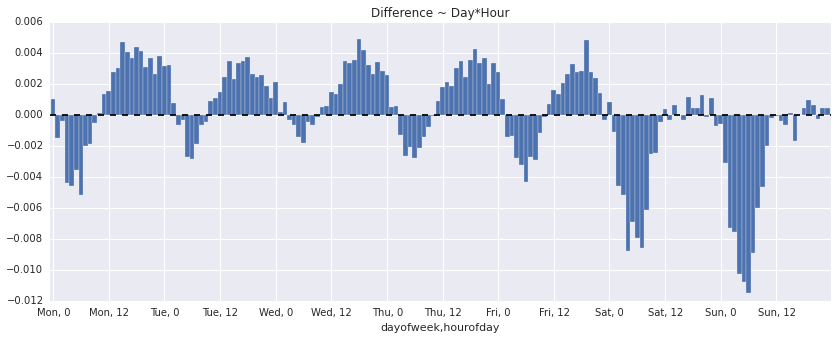

In [25]:
from itertools import product

ax = plot_groupby(dayhour, "Difference ~ Day*Hour", kind="bar", diff=1, width=1)
ax.set_xticks(xt)
ax.set_xticklabels(xtl, rotation=0)
print()

# User Graph Metrics as a Predictor

In [26]:
# Currently the user table is just a string, so we need to eval it and turn it into a table
lst = dt.set_index("predict").user.apply(str).apply(eval)
users = ~(lst.apply(type) == float)
t = lst[users]
du = pd.DataFrame.from_records(list(t), index=t.index)
du["predict"] = du.index
du["alcohol"] = (du.predict > 0.75).apply(int)
du.index = range(len(du))

In [27]:
du["normality"] = du.friends_count / (du.followers_count + du.friends_count + 1)
du["range"] = np.abs(du.followers_count - du.friends_count)
du["pop"] = (np.log(du.followers_count+1)) - np.log(du.friends_count+1)
du["harm"] = (du.followers_count + du.friends_count) / (1/(du.friends_count+1) + 1/(du.followers_count+1))

In [28]:
du_norm = du[
    ['favourites_count',
     'followers_count',
     'friends_count',
     'statuses_count',
     'normality',
     'range',
     'predict',
     'pop',
     'harm']
]

In [29]:
def density_plot(key, thres_range, log=False):
    d = du_norm[key] if not log else np.log(du_norm[key])
    for thres in thres_range:
        sns.kdeplot(d[du_norm.predict > (thres/100)], label="Alcohol@{}".format(thres), alpha=.4)
    
    sns.kdeplot(d, label="Everything", color="red")
    plt.title("{} Density".format(key.title()))

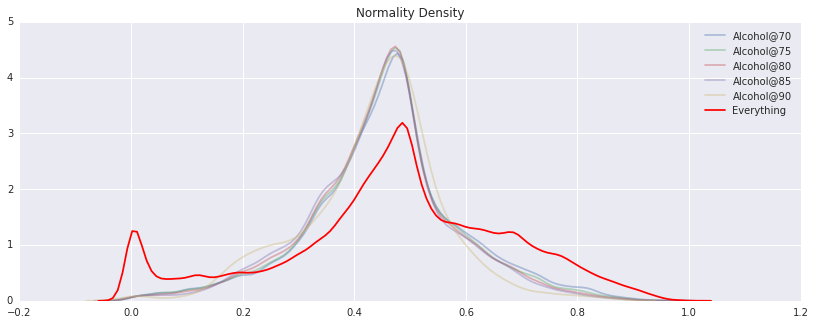

In [30]:
density_plot("normality", range(70, 95, 5))

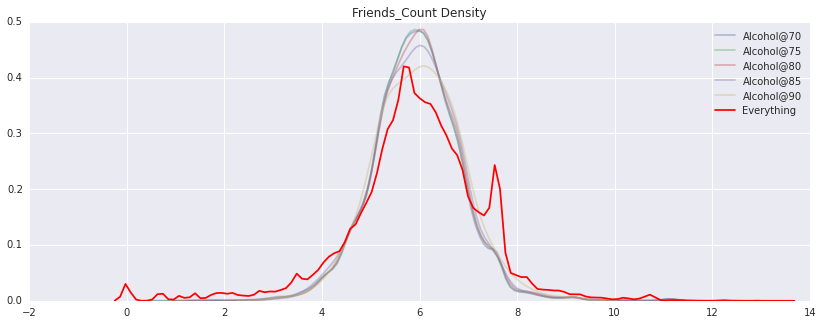

In [31]:
density_plot("friends_count",  range(70, 95, 5), log=1)

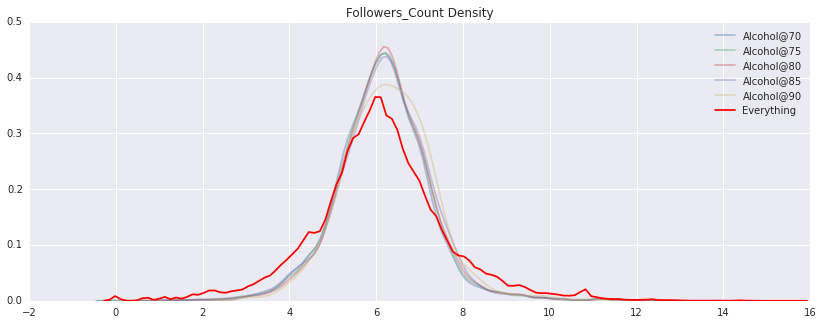

In [32]:
density_plot("followers_count",  range(70, 95, 5), log=1)

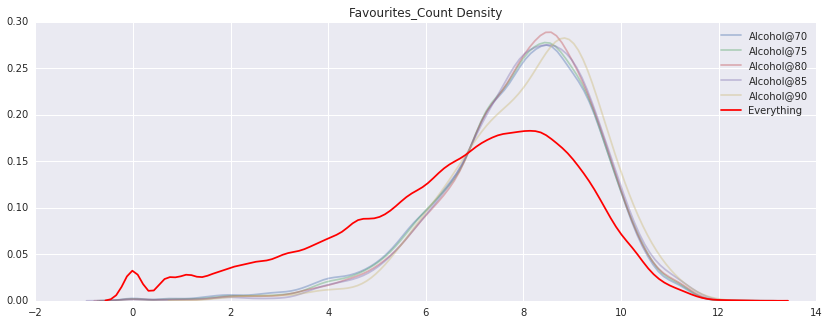

In [33]:
density_plot("favourites_count", range(70, 95, 5), log=1)

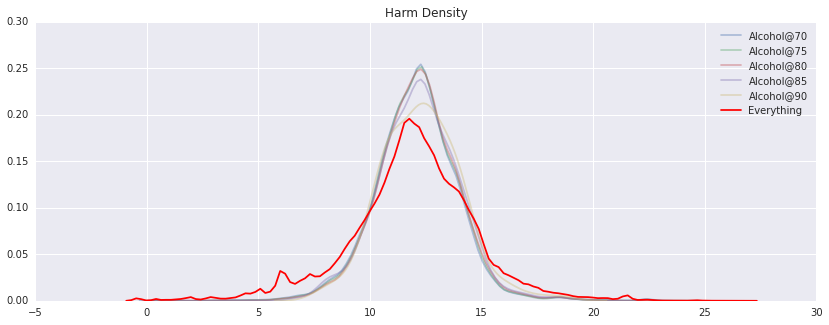

In [34]:
density_plot("harm", range(70, 95, 5), log=1)

# User Create Time as a Predictor

In [35]:
du["time"] = pd.to_datetime(du["created_at"], coerce=1, errors=1)

In [36]:
du["days_old"] = pd.to_datetime("2015-6-5") - du.time

In [37]:
days = du["days_old"].apply(int) // 6.048e14

In [38]:
days

0     182
1      32
2     290
3     233
4     173
5     228
6     299
7     226
8      63
9      72
10    320
11     99
12    340
13    319
14    201
...
566141    183
566142    119
566143     21
566144     67
566145    241
566146    312
566147    167
566148    326
566149    291
566150    354
566151    194
566152     27
566153    182
566154    329
566155     23
Name: days_old, Length: 566156, dtype: float64

## Index vs (Place/Location/State)

There are some questions about causation or whether to include this in the model.